# Loading Data

## Imports

In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow as tf

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Creating data loaders

In [2]:
train_df = pd.read_csv("df//train_df.csv")
val_df = pd.read_csv("df//val_df.csv")
train_df.head()

,path,pH
0,close_seg\6\6K--22-_jpg.rf.663142c881758efb4de...,6
1,close_seg\6\6k--75-_jpg.rf.42aa04547265d5890c7...,6
2,close_seg\6\6F--23-_jpg.rf.338da0e01de039e7b73...,6
3,close_seg\6\6F--44-_jpg.rf.1521f3dad55c9c68fd2...,6
4,close_seg\6\6k--13-_jpg.rf.47db8c03884b63f6b6f...,6


In [3]:
print(len(listdir("jpgData//6")))
print(len(listdir("jpgData//7")))
print(len(listdir("jpgData//8")))
print(len(listdir("jpgData//9")))

230
379
280
160


In [4]:
x_col = "path"
y_col = "pH"
batch_size = 32
epochs = 256
lr = 1e-4
image_size = (32,32)
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    #  width_shift_range = 0.1,
                                    #  height_shift_range = 0.1, 
                                    #  zoom_range = 0.2,
                                    #  shear_range = 0.5,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     channel_shift_range = 64.0,
                                    #  brightness_range = (0.3,1.0),
                                    #  rotation_range = 15,
                                     )
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size, color_mode = color_mode,
                                              shuffle = shuffle)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size,  color_mode = color_mode,
                                              shuffle = shuffle)


Found 512 validated image filenames.
Found 131 validated image filenames.


# Design Alternatives

## Design A: Nested U-Net

In [26]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
	# Applying the sequence of Convolutional, Batch Normalization
	# and Activation Layers to the input tensor
	x = Sequential([
		# Convolutional Layer
		Conv2D(num_filters, 1, padding='same'),
		# Batch Normalization Layer
		BatchNormalization(),
		# Activation Layer
		ReLU(),
		# Convolutional Layer
		Conv2D(num_filters, 1, padding='same'),
		# Batch Normalization Layer
		BatchNormalization(),
		# Activation Layer
		ReLU()
	])(inputs)

	# Returning the output of the Convolutional Block
	return x

# Defining the Unet++ Model
def unet_plus_plus_model(input_shape=(image_size[0], image_size[1], channels), num_classes=1, deep_supervision=True):
	inputs = Input(shape=input_shape)

	# Encoding Path
	x_00 = conv_block(inputs, 64)
	x_10 = conv_block(MaxPooling2D()(x_00), 128)
	x_20 = conv_block(MaxPooling2D()(x_10), 256)
	x_30 = conv_block(MaxPooling2D()(x_20), 512)
	x_40 = conv_block(MaxPooling2D()(x_30), 1024)

	# Nested Decoding Path
	x_01 = conv_block(concatenate(
		[x_00, UpSampling2D()(x_10)]), 64)
	x_11 = conv_block(concatenate(
		[x_10, UpSampling2D()(x_20)]), 128)
	x_21 = conv_block(concatenate(
		[x_20, UpSampling2D()(x_30)]), 256)
	x_31 = conv_block(concatenate(
		[x_30, UpSampling2D()(x_40)]), 512)

	x_02 = conv_block(concatenate(
		[x_00, x_01, UpSampling2D()(x_11)]), 64)
	x_12 = conv_block(concatenate(
		[x_10, x_11, UpSampling2D()(x_21)]), 128)
	x_22 = conv_block(concatenate(
		[x_20, x_21, UpSampling2D()(x_31)]), 256)

	x_03 = conv_block(concatenate(
		[x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
	x_13 = conv_block(concatenate(
		[x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

	x_04 = conv_block(concatenate(
		[x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

	# Deep Supervision Path
	# If deep supervision is enabled, then the model will output the segmentation maps
	# at each stage of the decoding path
	if deep_supervision:
		outputs = [
			Conv2D(num_classes, 1)(x_01),
			Conv2D(num_classes, 1)(x_02),
			Conv2D(num_classes, 1)(x_03),
			Conv2D(num_classes, 1)(x_04)
		]
		# Concatenating the segmentation maps
		outputs = concatenate(outputs, axis=0)

	# If deep supervision is disabled, then the model will output the final segmentation map
	# which is the segmentation map at the end of the decoding path
	else:
		flatten  = layers.Flatten()(x_04)
		dense = Dense(512, activation='relu')(flatten)
		dense = Dense(512, activation='relu')(dense)
		outputs = Dense(1)(dense)

	# Creating the model
	model = tf.keras.Model(
		inputs=inputs, outputs=outputs, name='Unet_plus_plus')

	# Returning the model
	return model




In [27]:
# Creating the model
modelA = unet_plus_plus_model(input_shape=(
	image_size[0], image_size[1], channels), deep_supervision=False)
modelA.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mean_squared_error', metrics=['mae'])
modelA.summary()

Model: "Unet_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_47 (Sequential)     (None, 32, 32, 64)   4928        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 16, 16, 64)  0           ['sequential_47[0][0]']          
 )                                                                                                
                                                                                                  
 sequential_48 (Sequential)     (None, 16, 16, 128)  25856       ['max_pooling2d_14[0

In [28]:


historyA = modelA.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10


16/16 [==============================] - 4s 74ms/step - loss: 14.0686 - mae: 2.5547 - val_loss: 48.0892 - val_mae: 6.8448
Epoch 2/10
16/16 [==============================] - 1s 43ms/step - loss: 2.0019 - mae: 1.1563 - val_loss: 40.8164 - val_mae: 6.2915
Epoch 3/10
16/16 [==============================] - 1s 42ms/step - loss: 1.3553 - mae: 0.9892 - val_loss: 31.3652 - val_mae: 5.4892
Epoch 4/10
16/16 [==============================] - 1s 42ms/step - loss: 1.2227 - mae: 0.9455 - val_loss: 26.3550 - val_mae: 5.0118
Epoch 5/10
16/16 [==============================] - 1s 42ms/step - loss: 1.1161 - mae: 0.8867 - val_loss: 18.5472 - val_mae: 4.1604
Epoch 6/10
16/16 [==============================] - 1s 42ms/step - loss: 1.2833 - mae: 0.9557 - val_loss: 14.6051 - val_mae: 3.6563
Epoch 7/10
16/16 [==============================] - 1s 42ms/step - loss: 1.1281 - mae: 0.8924 - val_loss: 9.9164 - val_mae: 2.9463
Epoch 8/10
16/16 [==============================] - 1s 42ms/step - loss: 1.0379 - mae: 

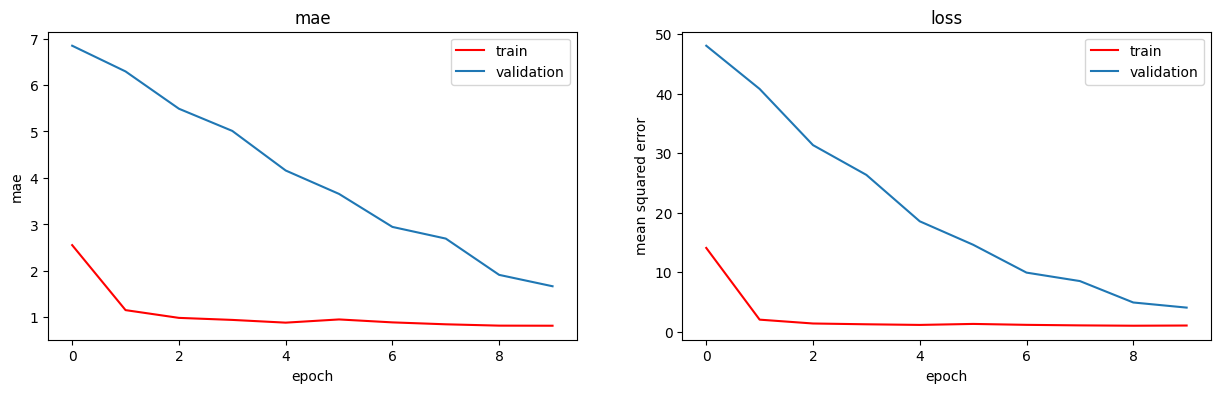

In [29]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(historyA.history['mae'], color ='r')
plt.plot(historyA.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyA.history['loss'], color ='r')
plt.plot(historyA.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean squared error')

# displaying the figure
plt.show()

In [30]:
## Best model saved
train_loss = historyA.history['loss']
train_mae = historyA.history['mae']
val_loss = historyA.history['val_loss']
val_mae = historyA.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train MAE: {:.2f}".format(train_mae[best_epoch]*100))
print("Final Test MAE: {:.2f}".format(val_mae[best_epoch]))

Best Epoch:  9
Final Train Loss: 1.0148
Final Validation Loss: 4.0275
Final Train MAE: 82.05
Final Test MAE: 1.67


## Design B: PSPNet

In [38]:
import tensorflow
import numpy as np
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Reshape, concatenate
from tensorflow.keras.layers import UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU, Lambda, Convolution2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Add, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras.backend as K

def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tensorflow.keras.layers.Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid' ,name='last_conv_relu')(X)
    # X = Flatten(name='last_conv_flatten')(X)
    return X

input_layer = tensorflow.keras.Input(shape=image_size+(channels,),name='input')
output_layer = last_conv_module(input_layer)
model = tensorflow.keras.Model(inputs=input_layer,outputs=output_layer)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr)
# IoU = tensorflow.keras.metrics.MeanIoU(num_classes=30)
metrics = ['mae']
model.compile(optimizer=optimizer,loss='mse', metrics = metrics)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 256, 256, 64), (None, 32, 32, 64), (None, 32, 32, 64), (None, 32, 32, 64)]

In [35]:
modelB = pspnet(input_shape=image_size+(3,))
modelB.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])
modelB.summary()

TypeError: The added layer must be an instance of class Layer. Received: layer=KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 512), dtype=tf.float32, name=None), name='concatenate_4/concat:0', description="created by layer 'concatenate_4'") of type <class 'keras.engine.keras_tensor.KerasTensor'>.

In [27]:
## MANUFACTURABILITY: TRAINING TIME
import time 
start = time.time()
historyB = modelB.fit(train_generator, epochs=10, validation_data=val_generator, verbose=0)
stop = time.time()
print(f"Training time: {stop - start}s")



Training time: 3.623995542526245s


In [ ]:
# ## Graphing Result of training
# plt.figure(figsize=(15,4))

# plt.subplot(121)
# plt.plot(historyB.history['mae'], color ='r')
# plt.plot(historyB.history['val_mae'])
# plt.title('mae')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mae')

# plt.subplot(122)
# plt.plot(historyB.history['loss'], color ='r')
# plt.plot(historyB.history['val_loss'])
# plt.title('loss')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mean squared error')

# # displaying the figure
# plt.show()

In [ ]:
# ## Best model saved
# train_loss = historyB.history['loss']
# train_mae = historyB.history['mae']
# val_loss = historyB.history['val_loss']
# val_mae = historyB.history['val_mae']

# best_epoch = np.argmin(np.array(val_loss))

# print("Best Epoch: ", best_epoch)
# print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
# print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
# print("Final Train MAE: {:.2f}".format(train_mae[best_epoch]*100))
# print("Final Test MAE: {:.2f}".format(val_mae[best_epoch]))

In [28]:
## FUNCTIONALITY: INFERENCE TIME
result = modelB.evaluate(train_generator[1][0], return_dict=True)
print(result)

1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
{'loss': 0.0, 'mae': 0.0}


In [29]:
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import r2_score
x_values = []
for i in range(100):
    x_values,y_values = next(train_generator)
predictions = modelB.predict(x_values)
cod = r2_score(y_values,predictions)
print(cod)

1/1 [==============================] - 0s 14ms/step
-3.812810852976205


In [22]:
## EFFICIENCY: STORAGE CONSUMPTION
weights = modelB.get_weights()
total_size = 0
for weight in weights:
    total_size += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_size*8e-6}")

Total model weight size in megabytes: 134.547976


In [124]:
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculae FLOPS
from keras_flops import get_flops
flops = get_flops(modelC, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\miniconda3\\envs\\tf\\Lib\\site-packages\\google\\~~otobuf\\internal\\_api_implementation.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [81]:
train_generator[1][1]

array([7, 6, 6, 7, 6, 6, 9, 8, 7, 9, 6, 6, 8, 6, 9, 8, 9, 6, 9, 9, 9, 6,
       6, 6, 7, 9, 7, 8, 9, 6, 9, 6], dtype=int64)

## Design C: DeepLabv3+


In [50]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    x = layers.GlobalAveragePooling2D()(x)
    x= Dense(1024, activation="relu",)(x)
    model_output = layers.Dense(1, activation='linear')(x)
    return keras.Model(inputs=model_input, outputs=model_output)


modelC = DeeplabV3Plus(image_size=image_size[0])
modelC.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [51]:
modelC.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])

historyC = modelC.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
16/16 [==============================] - 5s 91ms/step - loss: 34.3906 - mae: 5.6375 - val_loss: 52.2113 - val_mae: 7.1393
Epoch 2/10
16/16 [==============================] - 1s 42ms/step - loss: 7.5126 - mae: 2.3422 - val_loss: 37.2871 - val_mae: 6.0042
Epoch 3/10
16/16 [==============================] - 1s 42ms/step - loss: 1.6117 - mae: 1.0810 - val_loss: 24.7782 - val_mae: 4.8519
Epoch 4/10
16/16 [==============================] - 1s 43ms/step - loss: 1.4635 - mae: 1.0199 - val_loss: 23.5948 - val_mae: 4.7281
Epoch 5/10
16/16 [==============================] - 1s 43ms/step - loss: 1.2928 - mae: 0.9655 - val_loss: 22.3966 - val_mae: 4.5991
Epoch 6/10
16/16 [==============================] - 1s 44ms/step - loss: 1.2790 - mae: 0.9791 - val_loss: 12.6931 - val_mae: 3.3834
Epoch 7/10
16/16 [==============================] - 1s 42ms/step - loss: 1.2112 - mae: 0.9536 - val_loss: 10.4847 - val_mae: 3.0383
Epoch 8/10
16/16 [==============================] - 1s 43ms/step - loss: 1.

In [62]:
## MANUFACTURABILITY: TRAINING TIME
import time 
start = time.time()
historyC = modelC.fit(train_generator, epochs=10, validation_data=val_generator)
stop = time.time()
print(f"Training time: {stop - start}s")

## FUNCTIONALITY: INFERENCE TIME
modelC.evaluate(train_generator[1][0][0].reshape(1,32,32,3))

Epoch 1/10
16/16 [==============================] - 1s 45ms/step - loss: 1.2799 - mae: 0.9563 - val_loss: 2.5713 - val_mae: 1.3236
Epoch 2/10
16/16 [==============================] - 1s 41ms/step - loss: 1.2049 - mae: 0.9397 - val_loss: 2.5319 - val_mae: 1.3157
Epoch 3/10
16/16 [==============================] - 1s 41ms/step - loss: 1.2047 - mae: 0.9496 - val_loss: 1.9836 - val_mae: 1.1788
Epoch 4/10
16/16 [==============================] - 1s 41ms/step - loss: 1.2381 - mae: 0.9608 - val_loss: 2.0361 - val_mae: 1.1959
Epoch 5/10
16/16 [==============================] - 1s 42ms/step - loss: 1.2050 - mae: 0.9636 - val_loss: 1.3967 - val_mae: 0.9979
Epoch 6/10
16/16 [==============================] - 1s 41ms/step - loss: 1.1808 - mae: 0.9349 - val_loss: 1.3550 - val_mae: 1.0011
Epoch 7/10
16/16 [==============================] - 1s 41ms/step - loss: 1.1768 - mae: 0.9455 - val_loss: 1.6769 - val_mae: 1.0913
Epoch 8/10
16/16 [==============================] - 1s 42ms/step - loss: 1.1407 - m

(1, 32, 32, 3)

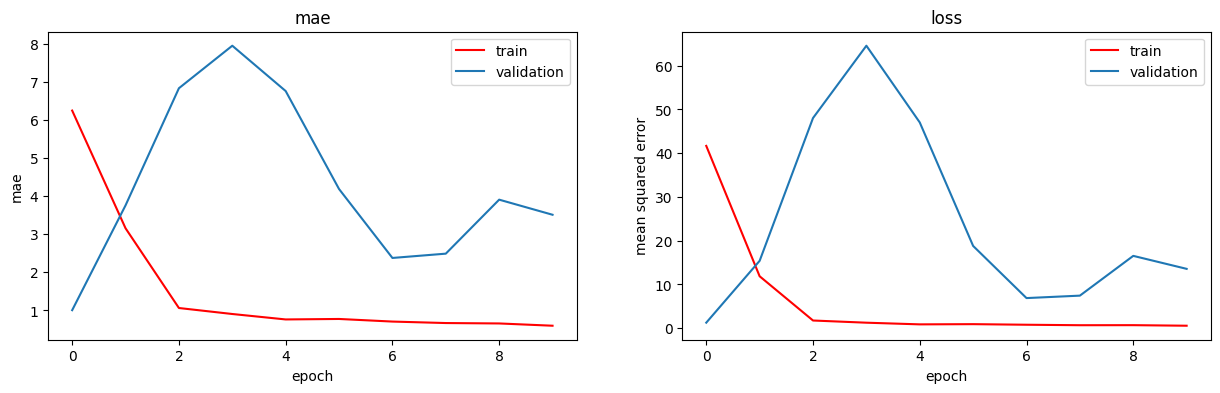

In [48]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(historyC.history['mae'], color ='r')
plt.plot(historyC.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyC.history['loss'], color ='r')
plt.plot(historyC.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean squared error')

# displaying the figure
plt.show()

In [49]:
## Best model saved
train_loss = historyC.history['loss']
train_mae = historyC.history['mae']
val_loss = historyC.history['val_loss']
val_mae = historyC.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train MAE: {:.2f}".format(train_mae[best_epoch]*100))
print("Final Test MAE: {:.2f}".format(val_mae[best_epoch]))

Best Epoch:  0
Final Train Loss: 41.6649
Final Validation Loss: 1.2598
Final Train MAE: 625.38
Final Test MAE: 1.01
